import librarie

In [ ]:
!pip install seaborn

In [ ]:
!pip install numpy pandas matplotlib scikit-learn flask

In [1]:
import pandas as pd
import numpy as np
from datetime import datetime
from sklearn.metrics import mean_absolute_error
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import LabelEncoder

load dataset

In [2]:
Document_path="../Data/Food data with festivals.csv"
food_data=pd.read_csv(Document_path)

preprocessing

In [4]:
def standardize_date(date_str):
    if not isinstance(date_str, str):
        date_str = str(date_str)
    for fmt in ('%d/%m/%Y', '%d-%m-%Y', '%Y-%m-%d', '%Y/%m/%d'):
        try:
            return datetime.strptime(date_str, fmt).strftime('%Y-%m-%d')
        except ValueError:
            continue
    print(f"Date format error for: {date_str}")
    raise ValueError(f'No valid date format found for {date_str}')


food_data['Date'] = food_data['Date'].astype(str)

def apply_standardize_date(date_series):
    standardized_dates = []
    for date in date_series:
        try:
            standardized_dates.append(standardize_date(date))
        except ValueError as e:
            print(e)
            standardized_dates.append(None)
    return standardized_dates

food_data['Date'] = apply_standardize_date(food_data['Date'])


food_data = food_data.dropna(subset=['Date'])


na_dates = food_data['Date'].isna().sum()
print(f"Number of NaT (Not a Time) values: {na_dates}")


Number of NaT (Not a Time) values: 0


feature engineering

In [5]:
## 1. Extract the day of the week
food_data['Day'] = pd.to_datetime(food_data['Date']).dt.day_name()

## 2. Add Seasons based on the month
def get_season(month):
    if month in [12, 1, 2]:
        return "Winter"
    elif month in [3, 4, 5]:
        return "Spring"
    elif month in [6, 7, 8]:
        return "Summer"
    else:
        return "Autumn"

food_data['Season'] = pd.to_datetime(food_data['Date']).dt.month.apply(get_season)

## 3. Add Is_weekend flag
food_data['Is_weekend'] = food_data['Day'].isin(['Saturday', 'Sunday'])

In [6]:
print("\nData after feature engineering:")
print(food_data.tail())


Data after feature engineering:
      order_id        Date      Item Name  Category  Price  Quantity  \
1195      1196  2023-12-31         Jalebi  Fastfood     50         1   
1196      1197  2023-12-03  Hot Chocolate  Beverage     40         2   
1197      1198  2023-12-26  Hot Chocolate  Beverage     40         2   
1198      1199  2023-12-30    Masala Chai  Beverage     25         1   
1199      1200  2023-12-05  Hot Chocolate  Beverage     40         1   

      Amount Transacted (?) Transaction Type  Gender Time of Sale  \
1195                     50             Cash    Male        Night   
1196                     80           Online  Female      Morning   
1197                     80           Online  Female      Morning   
1198                     25           Online    Male      Morning   
1199                     40             Cash    Male      Evening   

     Festival Name       Day  Season  Is_weekend  
1195           NaN    Sunday  Winter        True  
1196           Na

In [7]:
import os
food_data.columns = food_data.columns.str.strip()

food_data['Date'] = pd.to_datetime(food_data['Date'], errors='coerce')
for col in ['Item Name', 'Category', 'Gender', 'Time of Sale', 'Festival Name']:
    if col in food_data.columns:
        food_data[col] = food_data[col].str.strip()

## Check for missing values
missing_summary = food_data.isnull().sum()
print("Missing Values Summary:")
print(missing_summary)

## Strategy to handle missing values
# Numerical columns: Fill with mean
num_cols = food_data.select_dtypes(include=['float64', 'int64']).columns
food_data[num_cols] = food_data[num_cols].fillna(food_data[num_cols].mean())

# Categorical columns: Fill with 'Unknown' or mode
cat_cols = food_data.select_dtypes(include=['object']).columns
for col in cat_cols:
    food_data[col] = food_data[col].fillna(food_data[col].mode()[0])

## Drop rows with missing dates if any
food_data = food_data.dropna(subset=['Date'])

print("Preview of Cleaned Data:")
food_data.head()

Missing Values Summary:
order_id                    0
Date                        0
Item Name                   0
Category                    0
Price                       0
Quantity                    0
Amount Transacted (?)       0
Transaction Type            0
Gender                      0
Time of Sale                0
Festival Name            1070
Day                         0
Season                      0
Is_weekend                  0
dtype: int64
Preview of Cleaned Data:


,order_id,Date,Item Name,Category,Price,Quantity,Amount Transacted (?),Transaction Type,Gender,Time of Sale,Festival Name,Day,Season,Is_weekend
0,1,2023-01-07,Veg Pulao,Fastfood,12,1,12,Cash,Female,Afternoon,Mahashivratri,Saturday,Winter,True
1,2,2023-01-23,Paneer Butter Masala,Fastfood,62,3,186,Online,Male,Afternoon,Mahashivratri,Monday,Winter,False
2,3,2023-01-08,Rajma Chawal,Fastfood,223,2,446,Cash,Male,Afternoon,Mahashivratri,Sunday,Winter,True
3,4,2023-01-29,Upma,Fastfood,299,2,598,Online,Male,Morning,Mahashivratri,Sunday,Winter,True
4,5,2023-01-06,Chapati,Fastfood,36,1,36,Cash,Male,Afternoon,Mahashivratri,Friday,Winter,False


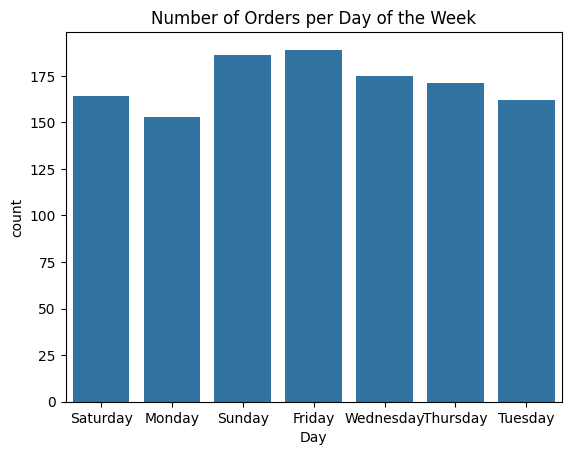

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.countplot(x='Day', data=food_data)
plt.title('Number of Orders per Day of the Week')
plt.show()

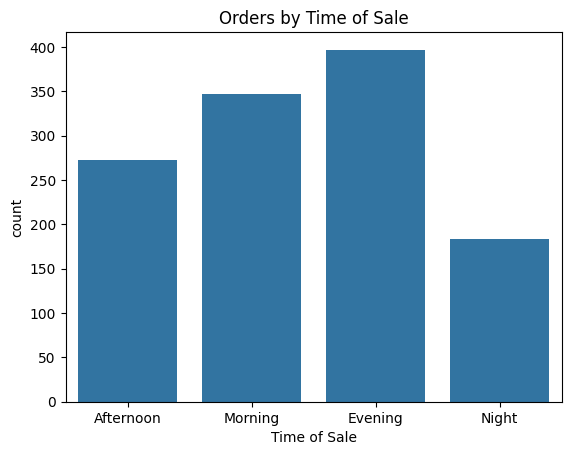

In [12]:
sns.countplot(x='Time of Sale', data=food_data)
plt.title('Orders by Time of Sale')
plt.show()

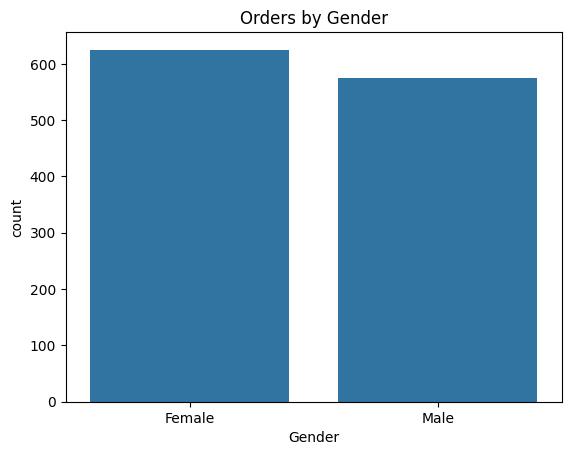

In [13]:
sns.countplot(x='Gender', data=food_data)
plt.title('Orders by Gender')
plt.show()

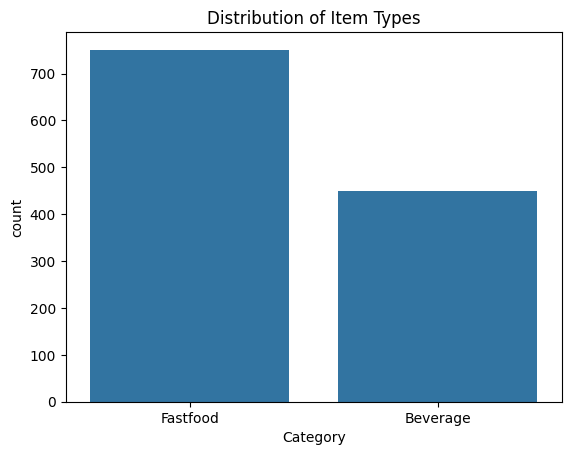

In [14]:
sns.countplot(x='Category', data=food_data)
plt.title('Distribution of Item Types')
plt.show()

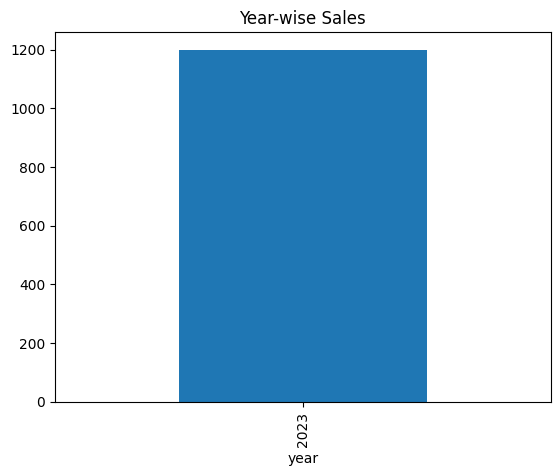

In [15]:
food_data['year'] = pd.to_datetime(food_data['Date'], format='%d/%m/%Y').dt.year
food_data.groupby('year').size().plot(kind='bar')
plt.title('Year-wise Sales')
plt.show()

In [8]:
food_data.rename(columns={
    'Item Name': 'Item_Name', 
    'Amount Transacted (₹)': 'Amount_Transacted_(₹)',
    'Transaction Type' : 'Transaction_Type',
    'Time of Sale' : 'Time_of_Sale',
    'Festival Name' : 'Festival_Name'
    }, inplace=True)

Clustering

In [9]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import LabelEncoder


In [10]:
data_encoded = food_data.copy()
label_encoders = {}
for column in ['Time_of_Sale','Category', 'Item_Name', 'Day', 'Gender','Festival_Name']:
    le = LabelEncoder()
    data_encoded[column] = le.fit_transform(data_encoded[column])
    label_encoders[column] = le
    
data_encoded.head()

,order_id,Date,Item_Name,Category,Price,Quantity,Amount Transacted (?),Transaction_Type,Gender,Time_of_Sale,Festival_Name,Day,Season,Is_weekend
0,1,2023-01-07,120,1,12,1,12,Cash,0,0,17,2,Winter,True
1,2,2023-01-23,82,1,62,3,186,Online,1,0,17,1,Winter,False
2,3,2023-01-08,94,1,223,2,446,Cash,1,0,17,3,Winter,True
3,4,2023-01-29,116,1,299,2,598,Online,1,2,17,3,Winter,True
4,5,2023-01-06,13,1,36,1,36,Cash,1,0,17,0,Winter,False


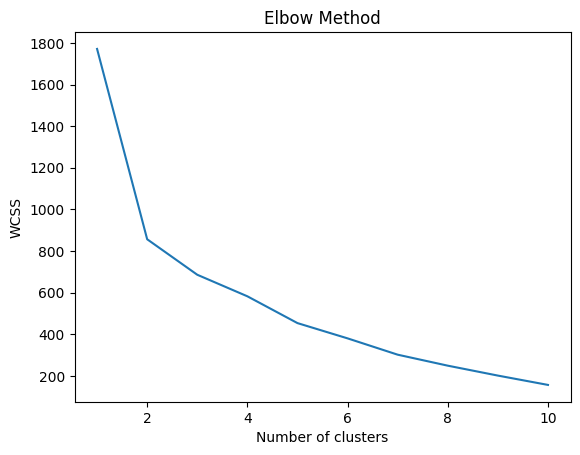


 Total number of clusters: 4
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1200 entries, 0 to 1199
Data columns (total 15 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   order_id               1200 non-null   int64         
 1   Date                   1200 non-null   datetime64[ns]
 2   Item_Name              1200 non-null   object        
 3   Category               1200 non-null   object        
 4   Price                  1200 non-null   int64         
 5   Quantity               1200 non-null   int64         
 6   Amount Transacted (?)  1200 non-null   int64         
 7   Transaction_Type       1200 non-null   object        
 8   Gender                 1200 non-null   object        
 9   Time_of_Sale           1200 non-null   object        
 10  Festival_Name          1200 non-null   object        
 11  Day                    1200 non-null   object        
 12  Season                 1200 non-

In [11]:
# Selecting relevant features
X = data_encoded[['Time_of_Sale', 'Gender','Category']]
# Determine optimal number of clusters using the elbow method
wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=0)
    kmeans.fit(X)
    wcss.append(kmeans.inertia_)

plt.plot(range(1, 11), wcss)
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

# Fit K-Means with optimal number of clusters
optimal_clusters = 4  # Replace with the determined number of clusters
kmeans = KMeans(n_clusters=optimal_clusters, init='k-means++', max_iter=300, n_init=10, random_state=0)
food_data['Cluster'] = kmeans.fit_predict(X)

# Print total number of clusters
print(f"\n Total number of clusters: {optimal_clusters}")

food_data.info()

Train Model using Random Forest

In [12]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler

In [13]:
food_data.drop(['Cluster','Is_weekend','Season'],axis=1,inplace=True)
food_data.head()

,order_id,Date,Item_Name,Category,Price,Quantity,Amount Transacted (?),Transaction_Type,Gender,Time_of_Sale,Festival_Name,Day
0,1,2023-01-07,Veg Pulao,Fastfood,12,1,12,Cash,Female,Afternoon,Mahashivratri,Saturday
1,2,2023-01-23,Paneer Butter Masala,Fastfood,62,3,186,Online,Male,Afternoon,Mahashivratri,Monday
2,3,2023-01-08,Rajma Chawal,Fastfood,223,2,446,Cash,Male,Afternoon,Mahashivratri,Sunday
3,4,2023-01-29,Upma,Fastfood,299,2,598,Online,Male,Morning,Mahashivratri,Sunday
4,5,2023-01-06,Chapati,Fastfood,36,1,36,Cash,Male,Afternoon,Mahashivratri,Friday


In [14]:
# Assuming food_data is your dataset

# Select the features (X) and target variable (y)
# Drop the 'Date' column and add the extracted datetime features
X = food_data.drop(columns=['Quantity', 'Date','order_id'])  
y = food_data['Quantity']  # Target variable is 'Quantity'


In [15]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [16]:
X_train.dtypes

Item_Name                object
Category                 object
Price                     int64
Amount Transacted (?)     int64
Transaction_Type         object
Gender                   object
Time_of_Sale             object
Festival_Name            object
Day                      object
dtype: object

In [17]:
y_train.dtypes

dtype('int64')

In [18]:
# Example categorical columns
# Update the categorical columns list
categorical_columns = ['Item_Name', 'Category', 'Time_of_Sale', 'Festival_Name', 'Day']
# Identify numerical columns
numerical_columns = ['Price', 'Amount Transacted (?)']

# Column transformer to one-hot encode categorical columns
preprocessor = ColumnTransformer(
    transformers=[
        ('num', Pipeline([
            ('imputer', SimpleImputer(strategy='mean')),  # Handle missing values in numerical columns
            ('scaler', StandardScaler())  # Standardize numerical columns
        ]), numerical_columns),
        
        ('cat', Pipeline([
            ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),  # Handle missing values in categorical columns
            ('onehot', OneHotEncoder(handle_unknown='ignore'))  # OneHotEncoding categorical columns
        ]), categorical_columns)
    ])


In [28]:
# Create a Random Forest Regressor model
model_random=Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', RandomForestRegressor(n_estimators=100, random_state=42))
])

In [20]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 960 entries, 331 to 1126
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   Item_Name              960 non-null    object
 1   Category               960 non-null    object
 2   Price                  960 non-null    int64 
 3   Amount Transacted (?)  960 non-null    int64 
 4   Transaction_Type       960 non-null    object
 5   Gender                 960 non-null    object
 6   Time_of_Sale           960 non-null    object
 7   Festival_Name          960 non-null    object
 8   Day                    960 non-null    object
dtypes: int64(2), object(7)
memory usage: 75.0+ KB


In [21]:
y_train.head()

331    1
409    1
76     4
868    1
138    3
Name: Quantity, dtype: int64

In [29]:
# Train the model
model_random.fit(X_train, y_train)


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['Price',
                                                   'Amount Transacted (?)']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(fill_value='missing',
                                                                                 strategy='constant')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['Item_Name', 'Category',
                                                   'Time_of_Sale',
                                                   'Festival_Name', 'Day'])])),
                ('regressor', RandomForestRegressor(random_state=42))])

In [30]:
# Train the model
model_random.fit(X_train, y_train)

# Make predictions
y_pred = model_random.predict(X_test)

# Evaluate the model
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f'Mean Absolute Error: {mae}')
print(f'R² (R-squared) value: {r2}')

Mean Absolute Error: 0.06587499999999999
R² (R-squared) value: 0.9841930979629712


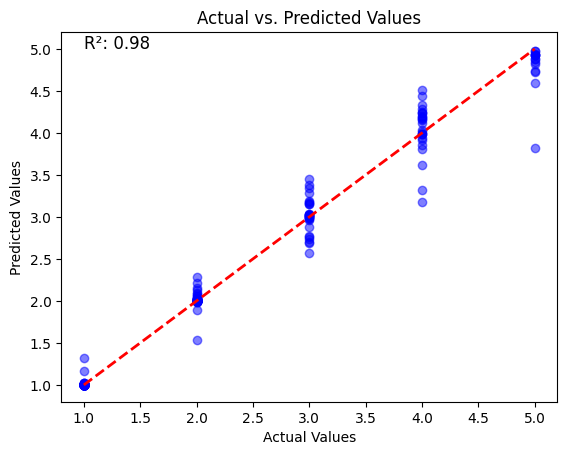

In [33]:
import matplotlib.pyplot as plt
import numpy as np

# Scatter plot of actual vs. predicted values
plt.scatter(y_test, y_pred, color='blue', alpha=0.5)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--', linewidth=2)
plt.title('Actual vs. Predicted Values')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')

# Annotate the R^2 value
plt.text(min(y_test), max(y_test), f'R²: {r2:.2f}', fontsize=12, color='black')

plt.show()


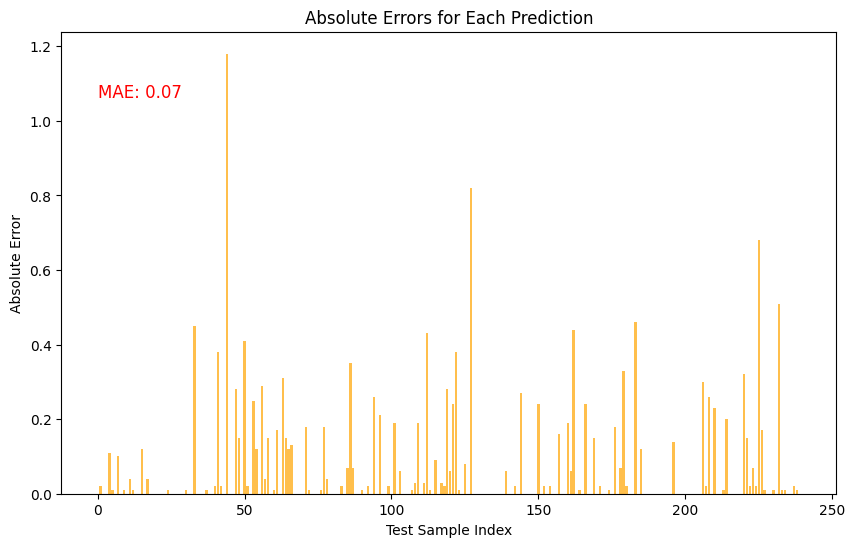

In [34]:
import matplotlib.pyplot as plt
import numpy as np

# Calculate absolute errors
absolute_errors = np.abs(y_test - y_pred)

# Bar plot of absolute errors
plt.figure(figsize=(10, 6))
plt.bar(range(len(absolute_errors)), absolute_errors, color='orange', alpha=0.7)
plt.title('Absolute Errors for Each Prediction')
plt.xlabel('Test Sample Index')
plt.ylabel('Absolute Error')
plt.text(0, max(absolute_errors)*0.9, f'MAE: {mae:.2f}', fontsize=12, color='red')
plt.show()


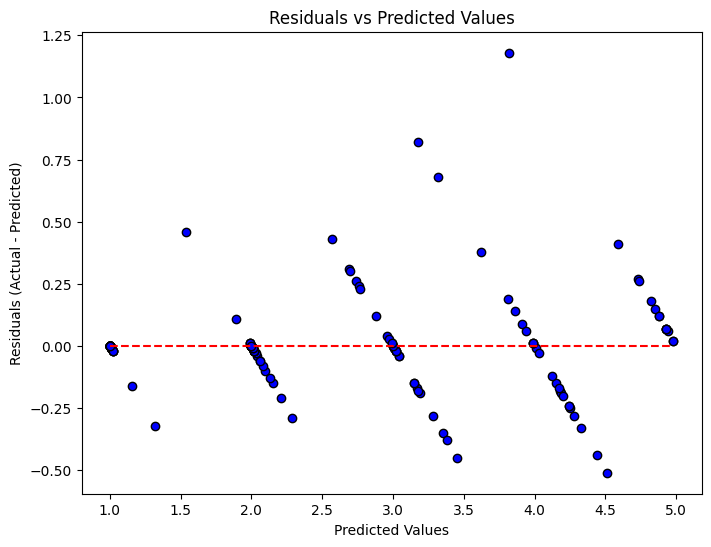

In [40]:
# Plotting Residuals (Actual - Predicted)
residuals = y_test - y_pred
plt.figure(figsize=(8, 6))
plt.scatter(y_pred, residuals, color='blue', edgecolors='black')
plt.hlines(y=0, xmin=min(y_pred), xmax=max(y_pred), color='red', linestyle='--')
plt.title("Residuals vs Predicted Values")
plt.xlabel("Predicted Values")
plt.ylabel("Residuals (Actual - Predicted)")
plt.show()

In [31]:
import joblib
joblib.dump(model_random, 'model_random.pkl')


['model_random.pkl']